In [1]:
import numpy as np
import sys
#sys.path.append('../utils/')
from utils import check_stochastic_matrix
import matplotlib.pyplot as plt
import copy
import networkx as nx
from scipy.linalg import eig

# Discrete Time Markov Chains
This is an exercise notebook on DTMCs. 

Remember to revise of the lecture on DTMC before attempting to solve it! 

#### Models

Consider few DTMCs, those seen in the lectures and few more:

1. Weather forecasting: the weather tomorrow is dependent on today’s weather. If today is rainy, half of the
times tomorrow will also be rainy; 40% will be cloudy; 10% will be sunny. If today is
cloudy, 20% of the times tomorrow will be rainy; 40% will be cloudy; 40% will be
sunny. If today is sunny, 10% of the times tomorrow will be rainy; 20% will be cloudy;
70% will be sunny. Can this be modeled as a DTMC? If the answer is yes, define the transition matrix as `transition_weather`.

In [2]:
#definition for a matrix to be a stochastic matrix
#every element positive
#rows sums to one
#dimension = state space squared

# Order of states: Rainy, Cloudy, Sunny
transition_weather = np.array([[0.5, 0.4, 0.1], [0.2, 0.4, 0.4], [0.1, 0.2, 0.7]])
transition_weather

weather={"sun":0,"cloud":1,"rain":2}
print("Sun transition probabilites: ",transition_weather[weather["sun"]])
print("\nCheck stochasticity: ",check_stochastic_matrix(transition_weather) )

Sun transition probabilites:  [0.5 0.4 0.1]

Check stochasticity:  True


2. The die simulator, `transition_die`. Define it. It has 13 states. Give also names to states and use a dictionary to match names with indexes in the matrix. 

![alt text](images/die.png)

In [3]:
def build_transition_die():
    k = {'s' + str(key): val for (key, val) in zip(range(13), range(13))}
    transition_die = np.zeros((13, 13))
    
    def set_val(state_a, state_b, val=0.5):
        transition_die[k[state_a]][k[state_b]] = val

    set_val('s0', 's1')
    set_val('s0', 's2')
    set_val('s1', 's3')
    set_val('s1', 's4')
    set_val('s2', 's5')
    set_val('s2', 's6')
    set_val('s3', 's1')
    set_val('s3', 's7')
    set_val('s4', 's8')
    set_val('s4', 's9')
    set_val('s5', 's10')
    set_val('s5', 's11')
    set_val('s6', 's2')
    set_val('s6', 's12')

    set_val('s7', 's7', 1)
    set_val('s8', 's8', 1)
    set_val('s9', 's9', 1)
    set_val('s10', 's10', 1)
    set_val('s11', 's11', 1)
    set_val('s12', 's12', 1)
    
    return transition_die

In [4]:
%%time
transition_die = build_transition_die()

print(transition_die)
print("\nCheck Stochasticity: ",check_stochastic_matrix(transition_die),"\n")

[[0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0. ]
 [0.  0.5 0.  0.  0.  0.  0.  0.5 0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5 0.5 0. ]
 [0.  0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]

Check Stochasticity:  True 

CPU times: user 4.46 ms, sys: 75 µs, total: 4.53 ms
Wall time: 3.96 ms


3. A general birth-death chain, `transition_birth_death()`. Define it writing a function that takes `N` as input (the maximum population size) and vectors `p` (the birth probability) and `q` (the death probability) of length N and returns the transition matrix `transition_birth_death`.

![alt text](images/birth-death.png)

In [5]:
def transition_birth_death(N, p, q):
    mdiag = np.ones(N)
    mdiag[:-1] -= p
    mdiag[1:] -= q
    matrix = np.zeros((N, N))
    matrix += np.diag(p, 1)
    matrix += np.diag(mdiag)
    matrix += np.diag(q, -1)
    
    return matrix

trans_birth_death = transition_birth_death(5, np.array([0.1,0.2,0.3,0.4]), np.array([0.1,0.2,0.3,0.4]))
print("\nTransition birth death:\n",trans_birth_death)
print("\nCheck stochasticity: ",check_stochastic_matrix(trans_birth_death) )


Transition birth death:
 [[0.9 0.1 0.  0.  0. ]
 [0.1 0.7 0.2 0.  0. ]
 [0.  0.2 0.5 0.3 0. ]
 [0.  0.  0.3 0.3 0.4]
 [0.  0.  0.  0.4 0.6]]

Check stochasticity:  True


3.1. Ehrenfest model of diffusion (second law of thermodynamics): imagine a room divided into two, with `N` molecules in total within the room. In every slot of time, a molecule is chosen uniformly and at random and moved to the opposite side. Let $X_n$ be the number of molecules on side 1 at time n.
Use the function `transition_birth_death()` to obtain the transition matrix of a Ehrenfest chain, which is an example of birth-death chain, call the transition matrix `transition_ehrenfest`.

4. The model of a queue of lenght `N`. Each state of the queue counts how many customers are waiting to be served. Two things can happen in state `i`: a new customer arrives (new state `i+1`), or a customer is served (new state `i-1`). The arrival rate is `l` and service rate in state `i` equal to `min(k,i)*mu`, where `k` is another parameter. In each state of the queue, the probability of arrival or service is proportional to the respective rate. Write a function taking `N,l,mu,k` as input and returning the `transition_queue` model as output. 

#### Transient probability
Write a function that takes a DTMC as input (both the transition matrix `transition_model` and the initial probability `prob_init_model`) and the number of steps `n`, and returns the probability `prob_model` of being in each state after `n` steps. Plot the output as an histogram. 
*Extra*: compute the transient probabilities from time 0 to time `n` and visualize this output as a 2d colormap, with one axis representing states, and the other time. 


In [6]:
class DTMC:
    def __init__(self, transition_model, init_prob_model):
        self.transition_model = transition_model
        self.init_prob_model = init_prob_model

N = 3
transition_weather = np.array([[0.5, 0.4, 0.1], [0.2, 0.4, 0.4], [0.1, 0.2, 0.7]])
prob_model = np.array([0.5, 0.2, 0.3])

# define the DTMC
weather_DTMC = DTMC(transition_weather, prob_model)
weather_map = {"sun":0,"cloud":1,"rain":2}

prob = [0.21749983 0.30442727 0.4780729 ] 
check sum = 1.0000000000000004


<BarContainer object of 3 artists>

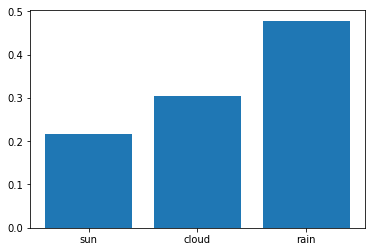

In [7]:
def compute_transient_prob(DTMC, n):
    power_matrix = np.linalg.matrix_power(DTMC.transition_model, n)
    final_prob_model = DTMC.init_prob_model.T.dot(power_matrix)
    return final_prob_model

transient_prob = compute_transient_prob(weather_DTMC, 10)
print("prob =",transient_prob, "\ncheck sum =", np.sum(transient_prob))
plt.bar(list(weather_map.keys()), height=transient_prob)


time 0 : [0.5 0.2 0.3]

time 1 : [0.32 0.34 0.34]

time 2 : [0.262 0.332 0.406]

time 3 : [0.238  0.3188 0.4432]

time 4 : [0.22708 0.31136 0.46156]

time 5 : [0.221968 0.307688 0.470344]

time 6 : [0.219556  0.3059312 0.4745128]

time 7 : [0.21841552 0.30509744 0.47648704]

time 8 : [0.21787595 0.30470259 0.47742146]

time 9 : [0.21762064 0.30451571 0.47786365]


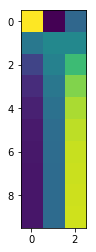

In [8]:
# 2d colormap: 
# x is the state
# y is the time 

n = 10
matrix = np.zeros([n,N])

for i in range(n):
    print("\ntime",i,":",compute_transient_prob(weather_DTMC, i))
    matrix[i]=compute_transient_prob(weather_DTMC, i)

plt.imshow(matrix)

#### Reachability (absorption probability) and hitting times.
Write a function that takes as input:
- a DTMC (the transition matrix `transition_model` is enough. Consider also defining a class describing a DTMC, containting `transition_model`, `prob_init_model`, and a map linking state numbers with names)
- a subset of states `target_region` (either specified by their name or by their indices)
The function should compute a vector `prob_absorption_model`, containing the absorption probability for each state. Use the iterative method discussed in the lecture. 

Implement also a method with the same input, returning the expected hitting times `exp_hitting_time_model`.

In [32]:
def compute_reachability(transition_model, target_region, ths):
    """ 
    same as before, but setting a ths on vector distance 
    instead of the number of iterations.
    """
    print("\ntransition matrix:\n",transition_model)
    print("\ntarget region:\n",target_region)
    
    # idxs for the updates
    update_idxs = list(set(range(len(transition_model)))-set(target_region))
    
    # set initial absorption probability for each state
    prob_absorption_model = np.zeros(len(transition_model))
    prob_absorption_model[target_region] = 1  
    print("\nstep 0:", prob_absorption_model)
    
    dist=1
    n=1
    while(dist > ths):
        old_abs_prob = copy.deepcopy(prob_absorption_model)
        prob_absorption_model[update_idxs] = transition_model[update_idxs].dot(prob_absorption_model.T)
        
        # update distance
        dist = np.linalg.norm(prob_absorption_model - old_abs_prob)
        print("\nstep",n,":", prob_absorption_model,"\tdist =", dist)
        n = n+1
        
    return prob_absorption_model

In [33]:
# weather chain 
target_region = [weather_map[x] for x in ['cloud','rain']]
compute_reachability(weather_DTMC.transition_model, target_region, 0.01)


transition matrix:
 [[0.5 0.4 0.1]
 [0.2 0.4 0.4]
 [0.1 0.2 0.7]]

target region:
 [1, 2]

step 0: [0. 1. 1.]

step 1 : [0.5 1.  1. ] 	dist = 0.5

step 2 : [0.75 1.   1.  ] 	dist = 0.25

step 3 : [0.875 1.    1.   ] 	dist = 0.125

step 4 : [0.9375 1.     1.    ] 	dist = 0.0625

step 5 : [0.96875 1.      1.     ] 	dist = 0.03125

step 6 : [0.984375 1.       1.      ] 	dist = 0.015625

step 7 : [0.9921875 1.        1.       ] 	dist = 0.0078125


array([0.9921875, 1.       , 1.       ])

In [25]:
# birth death chain
birth_death_DTMC = DTMC(trans_birth_death, [0.3, 0.2, 0.1, 0.3, 0.1])
target_region = [2, 3]
print(compute_reachability(birth_death_DTMC.transition_model, target_region, 0.1))


transition matrix:
 [[0.9 0.1 0.  0.  0. ]
 [0.1 0.7 0.2 0.  0. ]
 [0.  0.2 0.5 0.3 0. ]
 [0.  0.  0.3 0.3 0.4]
 [0.  0.  0.  0.4 0.6]]

target region:
 [2, 3]

step 0: [0. 0. 1. 1. 0.]

step 1 : [0.  0.2 1.  1.  0.4] 	dist = 0.447213595499958

step 2 : [0.02 0.34 1.   1.   0.64] 	dist = 0.2785677655436824

step 3 : [0.052 0.44  1.    1.    0.784] 	dist = 0.17821335527956375

step 4 : [0.0908 0.5132 1.     1.     0.8704] 	dist = 0.11970229738814546

step 5 : [0.13304 0.56832 1.      1.      0.92224] 	dist = 0.0866592037812488
[0.13304 0.56832 1.      1.      0.92224]


In [12]:
def compute_time(transition_model, target_region, ths):
    """ 
    compute the expected hitting time for target_region states
    """
    print("\ntransition matrix:\n",transition_model)
    print("\ntarget region:",target_region)
    
    # idxs for the updates
    update_idxs = list(set(range(len(transition_model)))-set(target_region))
    
    # set initial absorption probability for each state
    exp_hitting_time = np.zeros(len(transition_model))
    print("\nstep 0:", exp_hitting_time)
    
    dist=1
    n=1
    while(dist > ths):
        old_hitting_time = copy.deepcopy(exp_hitting_time)
        
        exp_hitting_time[update_idxs] = 1+transition_model[update_idxs].dot(exp_hitting_time.T)
        
        # update distance
        dist = np.linalg.norm(exp_hitting_time-old_hitting_time)
        print("\nstep",n,":", exp_hitting_time,"\tdist =", dist)
        n = n+1
        
    return exp_hitting_time

In [13]:
# weather chain
target_region = [weather_map[x] for x in ['cloud','rain']]
print(compute_time(weather_DTMC.transition_model, target_region, 0.01))


transition matrix:
 [[0.5 0.4 0.1]
 [0.2 0.4 0.4]
 [0.1 0.2 0.7]]

target region: [1, 2]

step 0: [0. 0. 0.]

step 1 : [1. 0. 0.] 	dist = 1.0

step 2 : [1.5 0.  0. ] 	dist = 0.5

step 3 : [1.75 0.   0.  ] 	dist = 0.25

step 4 : [1.875 0.    0.   ] 	dist = 0.125

step 5 : [1.9375 0.     0.    ] 	dist = 0.0625

step 6 : [1.96875 0.      0.     ] 	dist = 0.03125

step 7 : [1.984375 0.       0.      ] 	dist = 0.015625

step 8 : [1.9921875 0.        0.       ] 	dist = 0.0078125
[1.9921875 0.        0.       ]


In [14]:
# birth death chain
trans_birth_death = transition_birth_death(5, np.array([0.1,0.2,0.3,0.4]), np.array([0.1,0.2,0.3,0.4]))
init_prob = [0.3, 0.2, 0.1, 0.3, 0.1]
birth_death_DTMC = DTMC(trans_birth_death, init_prob)

target_region = [2, 3]
print(compute_time(birth_death_DTMC.transition_model, target_region, 0.8))


transition matrix:
 [[0.9 0.1 0.  0.  0. ]
 [0.1 0.7 0.2 0.  0. ]
 [0.  0.2 0.5 0.3 0. ]
 [0.  0.  0.3 0.3 0.4]
 [0.  0.  0.  0.4 0.6]]

target region: [2, 3]

step 0: [0. 0. 0. 0. 0.]

step 1 : [1. 1. 0. 0. 1.] 	dist = 1.7320508075688772

step 2 : [2.  1.8 0.  0.  1.6] 	dist = 1.4142135623730951

step 3 : [2.98 2.46 0.   0.   1.96] 	dist = 1.2351518125315608

step 4 : [3.928 3.02  0.    0.    2.176] 	dist = 1.122033867581545

step 5 : [4.8372 3.5068 0.     0.     2.3056] 	dist = 1.0394301515734476

step 6 : [5.70416 3.93848 0.      0.      2.38336] 	dist = 0.9716037677983754

step 7 : [6.527592 4.327352 0.       0.       2.430016] 	dist = 0.9118324809656655

step 8 : [7.307568  4.6819056 0.        0.        2.4580096] 	dist = 0.8572365236560557

step 9 : [8.04500176 5.00809072 0.         0.         2.47480576] 	dist = 0.8065279870456434

step 10 : [8.74131066 5.31016368 0.         0.         2.48488346] 	dist = 0.759075563938511
[8.74131066 5.31016368 0.         0.         2.48488346

#### Steady state probability

Write a function taking as input a DTMC and computes its steady state probability, assuming the chain is irreducible, aperiodic, and finite. 
*Extra*: explore Python libraries and find one implementing graph algorithms. Use a method to compute strongly connected components to check if a chain is irreducible. 

$\mu$ is an invariant measure for $\Pi$ iff $\mu^t\Pi=\mu$ iff $\mu^t([\Pi-I_n,1])=[0,1]$ iff $([\Pi-I_n,1])^t\mu=([0,1])^t$

In [15]:
def compute_steady_state(transient_matrix):
    # initialize the invariant measure
    n_vert = len(transient_matrix)
    invariant_measure = np.zeros(n_vert)
    
    # create a directed graph from the transient matrix
    G=nx.from_numpy_matrix(transient_matrix, create_using=nx.MultiDiGraph())
    
    # check if the chain is irreducible (only one SCC)
    if len(list(nx.strongly_connected_components(G))) == 1:        
        # compute the stable matrix
        #ones = np.repeat(1,n_vert)
        #A = np.vstack([transient_matrix-np.identity(n_vert).T,ones])
        #b = np.append(np.zeros(n_vert),[1])
        #print(A,"\n", b)
        
        # find the inv. measure as a left eigenvector for the transient matrix
        eigenvals, eigenvects = eig(transient_matrix.T)
        #steady_state_prob = np.linalg.solve(A, b) # unstable matrix case
        
        # return the eigenvector corresponding to eigenvalue 1
        idx_vec = np.where(eigenvals == 1.)
        steady_state_prob = eigenvects[:,idx_vec].flatten()
        return steady_state_prob
    
    else:
        print("\nThe chain is reducible.")

def is_invariant(mu, transient_matrix):
    return np.allclose(mu.dot(transient_matrix), mu)

In [16]:
transient_matrix = birth_death_DTMC.transition_model
mu = compute_steady_state(transient_matrix)
print(is_invariant(mu, transient_matrix))
# perché sono tutte uguali? 

True


#### Model class

Implement a class having all the methods to initialize a DTMC, to compute transient behaviour, steady state behaviour, and reachability. 

In [18]:
class DTMC:
    def __init__(self, transition_model, init_prob_model):
        self.transition_model = transition_model
        self.init_prob_model = init_prob_model
        
    def hitting_time(self, target_region, ths):
        return compute_time(self.transition_model, target_region, ths)
        
    def transient_prob(self, n_steps):
        power_matrix = np.linalg.matrix_power(self.transition_model, n_steps)
        final_prob_model = self.init_prob_model.T.dot(power_matrix)
        return final_prob_model
    
    def steady_state(self):
        return compute_steady_state(self.transition_model)
        
    def reachability(self, target_region, ths):
        return compute_reachability(self.transition_model, target_region, ths)

In [19]:
# usage example
trans_birth_death = transition_birth_death(5, np.array([0.1,0.2,0.3,0.4]), np.array([0.1,0.2,0.3,0.4]))
init_prob = np.array([0.3, 0.2, 0.1, 0.3, 0.1])
birth_death_DTMC = DTMC(trans_birth_death, init_prob)

In [20]:
birth_death_DTMC.hitting_time(target_region = [2, 3], ths=0.8)


transition matrix:
 [[0.9 0.1 0.  0.  0. ]
 [0.1 0.7 0.2 0.  0. ]
 [0.  0.2 0.5 0.3 0. ]
 [0.  0.  0.3 0.3 0.4]
 [0.  0.  0.  0.4 0.6]]

target region: [2, 3]

step 0: [0. 0. 0. 0. 0.]

step 1 : [1. 1. 0. 0. 1.] 	dist = 1.7320508075688772

step 2 : [2.  1.8 0.  0.  1.6] 	dist = 1.4142135623730951

step 3 : [2.98 2.46 0.   0.   1.96] 	dist = 1.2351518125315608

step 4 : [3.928 3.02  0.    0.    2.176] 	dist = 1.122033867581545

step 5 : [4.8372 3.5068 0.     0.     2.3056] 	dist = 1.0394301515734476

step 6 : [5.70416 3.93848 0.      0.      2.38336] 	dist = 0.9716037677983754

step 7 : [6.527592 4.327352 0.       0.       2.430016] 	dist = 0.9118324809656655

step 8 : [7.307568  4.6819056 0.        0.        2.4580096] 	dist = 0.8572365236560557

step 9 : [8.04500176 5.00809072 0.         0.         2.47480576] 	dist = 0.8065279870456434

step 10 : [8.74131066 5.31016368 0.         0.         2.48488346] 	dist = 0.759075563938511


array([8.74131066, 5.31016368, 0.        , 0.        , 2.48488346])

In [21]:
birth_death_DTMC.transient_prob(n_steps=10)

array([0.23769997, 0.20764528, 0.19137523, 0.1832303 , 0.18004922])

In [22]:
birth_death_DTMC.steady_state()

array([-0.4472136, -0.4472136, -0.4472136, -0.4472136, -0.4472136])

In [23]:
birth_death_DTMC.reachability(target_region=[2, 3], ths=0.1)


transition matrix:
 [[0.9 0.1 0.  0.  0. ]
 [0.1 0.7 0.2 0.  0. ]
 [0.  0.2 0.5 0.3 0. ]
 [0.  0.  0.3 0.3 0.4]
 [0.  0.  0.  0.4 0.6]]

target region:
 [2, 3]

step 0: [0. 0. 1. 1. 0.]

step 1 : [0.  0.2 1.  1.  0.4] 	dist = 0.447213595499958

step 2 : [0.02 0.34 1.   1.   0.64] 	dist = 0.2785677655436824

step 3 : [0.052 0.44  1.    1.    0.784] 	dist = 0.17821335527956375

step 4 : [0.0908 0.5132 1.     1.     0.8704] 	dist = 0.11970229738814546

step 5 : [0.13304 0.56832 1.      1.      0.92224] 	dist = 0.0866592037812488


array([0.13304, 0.56832, 1.     , 1.     , 0.92224])

#### Simulation of DTMC
Write a method that simulates a DTMC for `n` steps, where `n` is a parameter of the method, and returns the whole trajectory as output.

In [45]:
birth_death_DTMC.transition_model[4]

array([0. , 0. , 0. , 0.4, 0.6])

In [59]:
del simulate_trajectory

In [86]:
def simulate_trajectory(DTMC, n):
    n_states = len(DTMC.init_prob_model)
    trajectory = np.zeros(n, dtype=int)
    trajectory[0] = np.random.choice(n_states, p = DTMC.init_prob_model)
    for i in range(1,n):
        trajectory[i] = np.random.choice(n_states, p = DTMC.transition_model[trajectory[i-1]])
    return trajectory

In [101]:
# simulate a random trajectory
simulate_trajectory(birth_death_DTMC, n=20)

array([3, 3, 3, 3, 3, 2, 2, 3, 2, 3, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3])

#### Statistical analysis
Write methods for:
- computing the average of a function `f` of the state space, at time step `n`.
- computing the probability of reaching a target region `A` of the state space by time step `n`.
Both methods should use simulation, and return an estimate and a confidence interval at a specified confidence level `alpha` (0.95% by default).

In [131]:
import statsmodels.stats.api as sms

In [138]:
def compute_average(DTMC, f, n):
    states = np.zeros(n)
    for i in range(n):
        states[i] = simulate_trajectory(DTMC, n)[-1]
    average = np.mean(f(states))
    conf_int = sms.DescrStatsW(states).tconfint_mean()

    return {'average':average, 'confidence_interval':conf_int}

# f = function of the state space
f = np.vectorize(lambda x: 1 if (x in [2,3]) else 0)

# n = target time step
compute_average(birth_death_DTMC, f, 10)

{'average': 0.2,
 'confidence_interval': (0.17480988883799076, 2.6251901111620093)}

In [ ]:
def prob_reaching_target()

#### Branching chain
Consider a population, in which each individual at each
generation independently gives birth to $k$ individuals with
probability $p_k$. These will be the members of the next
generation. Assume $k\in\{-1, 0,1,2\}$. 

Question: under which conditions the population will become extinct?

#### Bonus: Snakes and Ladders game